In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# If you use google colab, make sure to mount your drive before proceed
from google.colab import drive
# Mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Data Preprocessing
##<li> Loading the dataset
##<li> Rescale the pixel value to between 0-1
##<li> Splitting the dataset into train test and validation set


In [ ]:
# Load the MNIST dataset
df = pd.read_csv("/content/drive/MyDrive/RD-Lab-CNN-Code/mnist_digits.csv") # Path to your MNIST dataset

print(df.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

### The first column of the table is the true label or target of the image. Since this dataset consists of handwritten digits, the target ranges from 0-9 (number 0 to 9). The rest of the column indicate individual pixel within the image. The image is 28x28, therefore there are 784 pixels in total. Each row represent an image, 42,000 rows equate to 42,000 images in this dataset.

In [ ]:
# Seperating the labels or targets from the image's pixels
targets = df["label"].values # Getting the label and store it in a variable
pixels = df.drop("label", axis=1).values # Dropping the label column and storing only the pixels

print(targets)
print(f"There are {len(targets)} images in this dataset")

[1 0 1 ... 7 6 9]
There are 42000 images in this dataset


In [ ]:
# Rescale pixel values to the range 0-1
pixels = pixels / 255.0 # Image pixel ranges from 0-255

# Reshape the images to 28x28 for visualization and CNN input
pixels = pixels.reshape(-1, 28, 28, 1)  # re-arrange each rows (each pixel) in the dataset into a 2 dimensional array of size 28x28 and 1 channel (grayscale)

print(f"Dataset shape: {pixels.shape}, Labels shape: {targets.shape}")

Dataset shape: (42000, 28, 28, 1), Labels shape: (42000,)


42,000 refers to the amount of image  
(28, 28, 1) refers to the size of the image and the channel. Since this is a grayscale image, it only has 1 channel.

In [ ]:
# Splitting the dataset into 70% training, 20% testing and 10% validation
X_train, X_test, y_train, y_test = train_test_split(pixels, targets, test_size=0.2, random_state=123) # random_state allow us to reproduce the exact split again
X_train, X_val, y_train, y_val = train_test_split(pixels, targets, test_size=(1/8), random_state=123) # 1/8 of 80% is 10% of the overall dataset

# Check how much images are in each sets
print("Training set:", len(y_train))
print("Validation set:",  len(y_val))
print("Testing set:", len(y_test))

Training set: 36750
Validation set: 5250
Testing set: 8400


After the split we got:  


*   36,750 images for training  
*   8,400 images for testing
*   5,250 images for validation





  


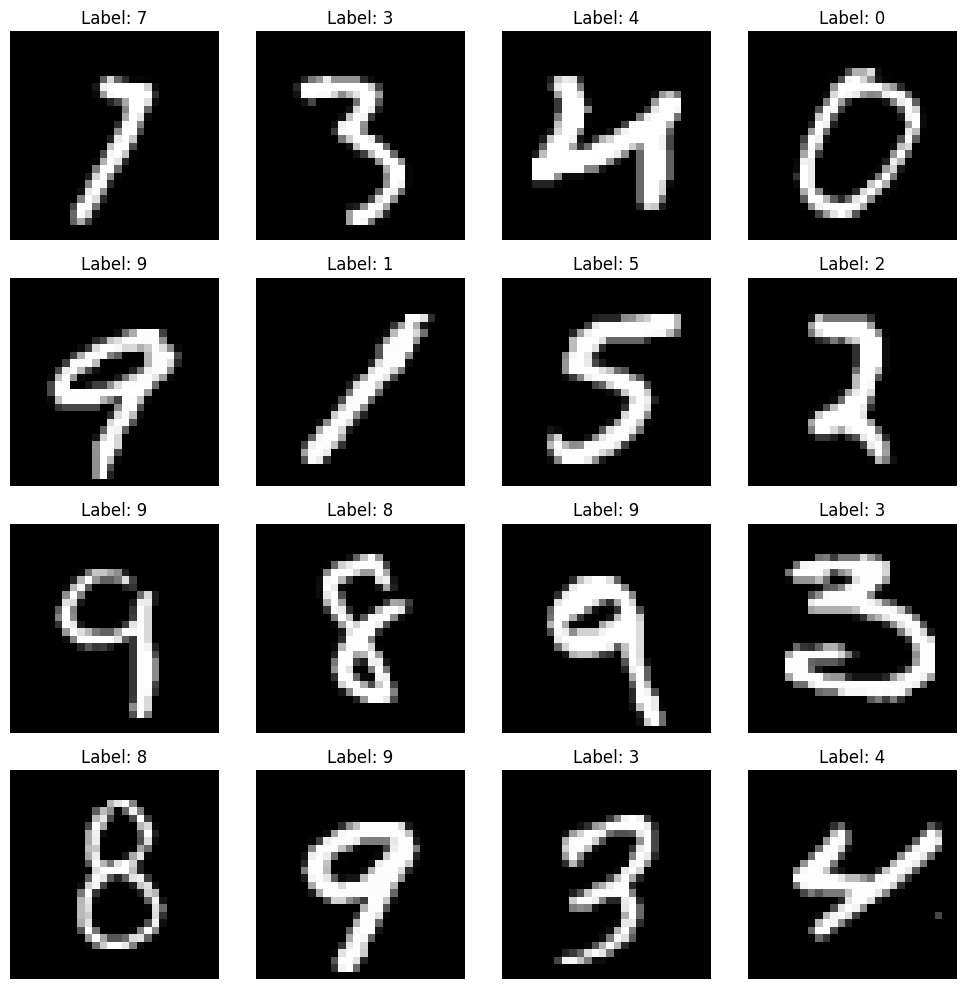

In [ ]:
# Plot some images
plt.figure(figsize=(10, 10))  # Set the figure size
for i in range(16):  # Plot the first 16 images
    plt.subplot(4, 4, i + 1)  # Create 4x4 grid to plot the images
    plt.imshow(X_train[i], cmap="gray")  # Display the image in grayscale
    plt.title(f"Label: {y_train[i]}")  # Add the label as the title
    plt.axis("off")  # Turn off axis

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# 2. Building Modified LeNet-5

### LeNet-5, introduced by Yann LeCun in 1998, is one of the earliest convolutional neural network (CNN) architectures and was designed for handwritten digit recognition, such as the MNIST dataset. It is a compact and efficient model that combines convolutional layers for feature extraction and fully connected layers for classification. LeNet-5 set the foundation for modern deep learning architectures and demonstrated the power of CNNs for image-related tasks.

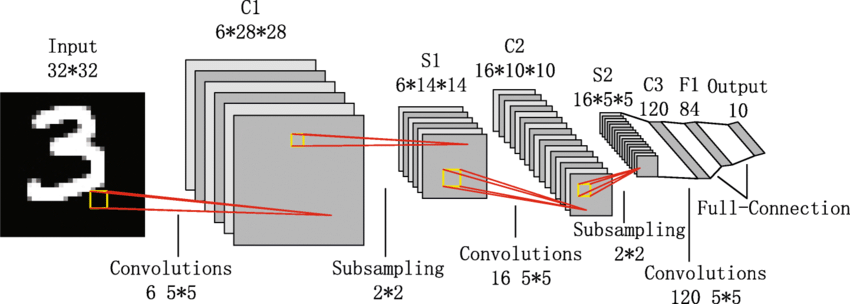

### For the purpose of our study, we will modify LeNet-5 subsampling layers, and replace it with average-pooling layers due to their similarity. During the time of LeNet-5 creation, pooling-layers were yet to be invented, hence it uses subsampling as a mean to reduce the feature map size.  
## Layer-by-layer breakdown of Modified LeNet-5
### 1. Input layer:
#####<li> Input Size: 28×28 (grayscale image)  
### 2. Convolutional layer 1 (C1)  
#####<li> Filters: 6 filters of size 5x5
#####<li> Padding: None
#####<li> Strides: 1
#####<li> Activation: Tanh
### 3. Average-pooling layer 1 (S2)  
#####<li> Filters size: 2x2
#####<li> Strides: 2
### 4. Convolutional layer 2 (C3)  
#####<li> Filters: 16 filters of size 5x5
#####<li> Padding: None
#####<li> Strides: 1
####<li> Activation: Tanh
### 5. Average-pooling layer 2 (S4)  
#####<li> Filters size: 2x2
#####<li> Strides: 2
### 6. Convolutional layer 3 (C5)  
#####<li> Input: The output of Layer S4, consisting of 16 feature maps, each of size 5×5
#####<li> Feature maps: 120
#####<li> Filter size: 4x4
####<li> Activation: Tanh
### 7. Fully connected layer (F6)  
#####<li> Neurons: 84
####<li> Activation: Tanh
### 8. Output layer
#####<li> Neurons: 10
####<li> Activation: Softmax







In [ ]:
def create_LeNet5(input_shape):
  model = models.Sequential([

      # C1 and inputs
      layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(input_shape), padding="valid", name="C1"),

      # S2 Average pooling
      layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name="S2"),

      # C3
      layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="valid", name="C3"),

      #S4
      layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name="S4"),

      #C5 (kernel size is smaller than original LeNet-5 in this layer because our images are smaller than what LeNet-5 was trained on)
      layers.Conv2D(filters=120, kernel_size=(4, 4), strides=(1, 1), activation='tanh', padding="valid", name="C5"),

      #F6
      layers.Flatten(name="Flatten"), # Convert all features map into 1D vector for fully connected layer to process

      layers.Dense(units=84, activation='tanh', name="F6"),
      # layers.Dropout(0.5, name="Dropout"), # Disable 50% of the neuron to avoid overfitting,

      # Output Layer
      layers.Dense(units=10, activation='softmax', name="Output") # Units=10 because there are 10 classes (0-9)

  ], name="modifiedLeNet5")
  return model

LeNet5 = create_LeNet5(input_shape=(28, 28, 1)) # (28, 28, 1) is the shape of our images

# Compile the model
# Experiment with these optimizer to see different results
SGD = SGD(learning_rate=0.01)  # Specify the learning rate
RMSprop = RMSprop(learning_rate=0.01)  # Specify the learning rate
Adam = Adam(learning_rate=0.01)  # Specify the learning rate

# sparse categorical crossentropy is a common loss function for multi-class classification
LeNet5.compile(optimizer=SGD, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
LeNet5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "modifiedLeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 24, 24, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (AveragePooling2D)                │ (None, 12, 12, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C3 (Conv2D)                          │ (None, 8, 8, 16)            │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S4 (AveragePooling2D)                │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 1, 1, 120)           │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ F6 (Dense)                           │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
BATCH_SIZE = 128 # Hyperparamters
EPOCHS = 10 # Hyperparameters

seed_value = 42 # Set seed to reproduce results during training

tf.random.set_seed(seed_value)
# Train the model
history = LeNet5.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                     shuffle=True)  # Validation data to evaluate performance during training

Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.3734 - loss: 2.1126 - val_accuracy: 0.7857 - val_loss: 1.0401
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.8127 - loss: 0.8622 - val_accuracy: 0.8594 - val_loss: 0.5774
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.8646 - loss: 0.5426 - val_accuracy: 0.8773 - val_loss: 0.4615
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8820 - loss: 0.4455 - val_accuracy: 0.8872 - val_loss: 0.4055
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8900 - loss: 0.3947 - val_accuracy: 0.8949 - val_loss: 0.3700
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8969 - loss: 0.3612 - val_accuracy: 0.9019 - val_loss: 0.3439
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.9024 - loss: 0.3361 - val_accuracy: 0.9088 - val_loss: 0.3228
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9073 - loss: 0.3155 - 

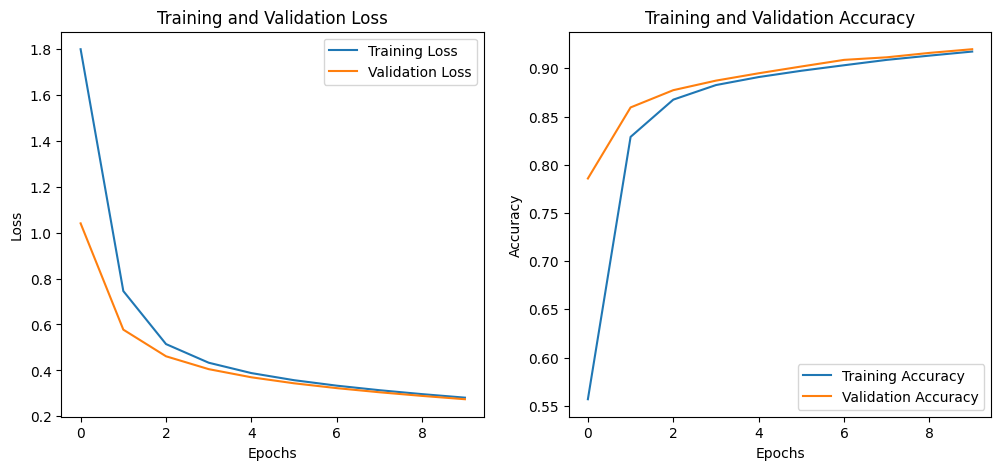

In [ ]:
# Extract metrics
loss = history.history['loss'] # Getting the training loss history of training
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5)) # Define the size of the plot
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss') # plotting the training loss graph
plt.plot(val_loss, label='Validation Loss') # plotting the validation loss graph
plt.xlabel('Epochs') # plotting the labels
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy') # plotting the training accuracy graph
plt.plot(val_accuracy, label='Validation Accuracy') # plotting the validation accuracy graph
plt.xlabel('Epochs') # plotting the labels
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Judging by the graph, the LeNet-5 model was bale to converge nicely, meaning the model was able to find optimal weights and biases given the constraint of the architecture. The model was able to perform exceptionally well on the training set, which is understandable considering the model is trained on the training set.  
Overal, the model was able to achieve an accuracy of 91.53% on the training set, and 91.98% on the validation set.

In [ ]:
# Evaluating the final model on test set
test_loss, test_accuracy = LeNet5.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9176 - loss: 0.2760
Test Loss: 0.27117687463760376
Test Accuracy: 0.9202380776405334


The LeNet-5 model was able to accurately predict 92.02% of the dataset with a loss of 0.2711

263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


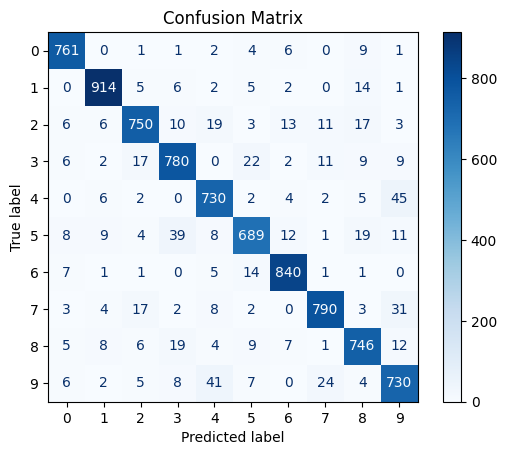

In [ ]:
# Predict class labels for the test set
predicted_classes = np.argmax(LeNet5.predict(X_test), axis=1)
true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))  # Assuming classes 0-9
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

<li>The rows represent the actual labels (true labels).
<li>The columns represent the predicted labels.
<li>Each cell contains the number of instances that fall into that combination of predicted and true class.

In [ ]:
# Select a few test samples
num_samples = 10  # Number of samples to visualize
indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

# Get the selected images and true labels
sample_images = X_test[indices]
sample_true_labels = y_test[indices]

 # Get predictions
sample_predictions = np.argmax(LeNet5.predict(sample_images), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


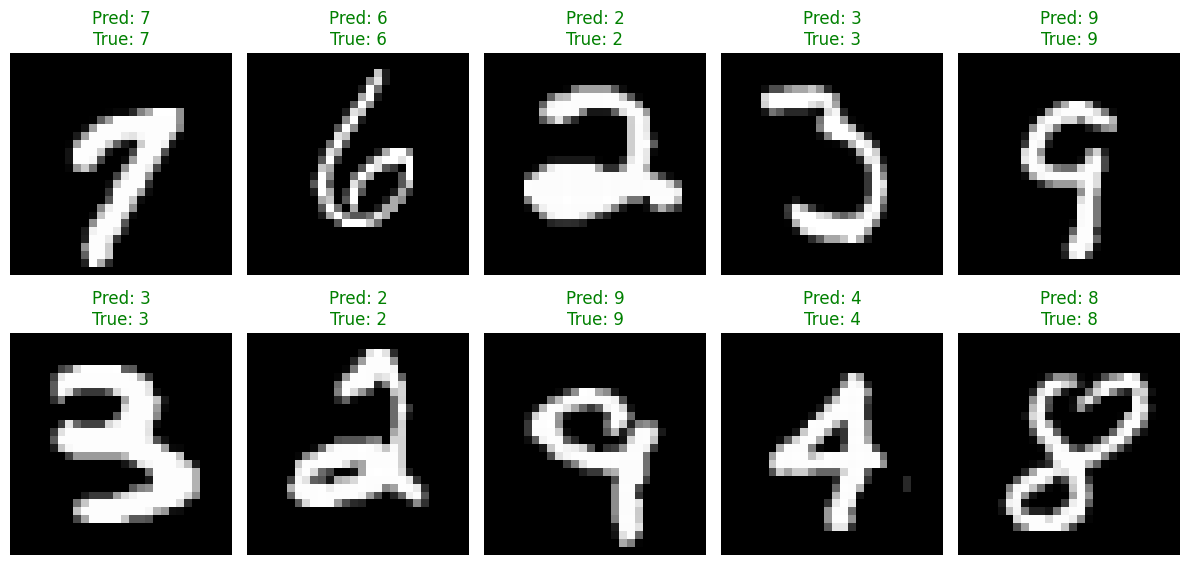

In [ ]:
# Plot the images with predicted and true labels
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows, 5 columns
    plt.imshow(sample_images[i].squeeze(), cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    color = "green" if sample_predictions[i] == sample_true_labels[i] else "red"
    plt.title(f"Pred: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=color)
plt.tight_layout()
plt.show()

In [ ]:
# Saving the model, which we can use and apply it on other application
LeNet5.save("lenet5_model.h5")


#Appendix

In [ ]:
# Data augmentation code using tensorflow
"""
  Why data augmentation is needed:
    --Increases Dataset Size: Expands small datasets, reducing overfitting.
    --Improves Generalization: Makes the model more robust to variations (e.g., rotation, lighting).
    --Prevents Overfitting: Encourages the model to focus on general patterns, not specifics.
    --Simulates Real-World Variations: Exposes the model to different conditions.
    --Boosts Performance with Limited Data: Useful when datasets are small.
    --Improves Convergence: Helps the model converge faster by presenting diverse data.
"""
import tensorflow as tf

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)     # Random vertical flip
    image = tf.image.random_rotation(image, 0.2)    # Random rotation
    image = tf.image.random_zoom(image, 0.2)        # Random zoom
    image = tf.image.random_brightness(image, 0.1)  # Random brightness adjustment
    return image, label

# Create a tf.data.Dataset from your training data (e.g., x_train, y_train)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Apply the augmentation function to the dataset
train_dataset = train_dataset.map(augment_image)

# Batch and shuffle the data for training
train_dataset = train_dataset.batch(32).shuffle(1000)

# Now, you can train your model with this dataset
LeNet5.fit(train_dataset, epochs=10)
